In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from datetime import datetime, timedelta

from scipy import stats
import statsmodels.api as sm
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Price Prediction of Ethereum's Cryptocurrency Ether (ETH)

## Using Deep Learning Models to Predict Price Movements

![Alt text](https://i.imgur.com/WA1O1ci.jpg)

## Problem Introduction

Following my previous project dedicated to ETH Price Prediction using Machine Learning models, I am now attempting to do the same thing, but employing the ARIMA model and a Deep Convolutional Neural Network. 

The dataset I used consists of historical price data for the ETH cryptocurrency. 

I have taken ideas and inspiration from several Kaggle notebooks as well as from research papers on [Ethereum price forecasting](https://arno.uvt.nl/show.cgi?fid=157717) and on using [Time Series Analysis to predict stock prices](https://arxiv.org/ftp/arxiv/papers/2004/2004.11697.pdf).

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices()[1], True)

## Model I: ARIMA

In [5]:
eth = pd.read_csv("C:/Users/35989/Desktop/AI/Machine Learning/Final Project/ethereum_2015-08-07_2022-11-20.csv")
eth

,Date,Open,High,Low,Close,Volume,Market Cap
0,Nov-18-2022,1212.813971,1227.419300,1200.788200,1218.902299,9.537880e+09,1.480340e+11
1,Nov-17-2022,1200.797267,1227.657224,1200.797267,1213.309305,1.570107e+10,1.485864e+11
2,Nov-16-2022,1217.596530,1226.466113,1188.083400,1200.163955,1.915299e+10,1.475286e+11
3,Nov-15-2022,1253.747300,1265.637300,1194.687196,1217.306892,2.033123e+10,1.506058e+11
4,Nov-14-2022,1242.079348,1285.393600,1238.715646,1252.796100,2.368056e+10,1.543662e+11
...,...,...,...,...,...,...,...
2656,Aug-11-2015,1.067860,1.289940,0.883608,1.237670,1.971841e+06,6.682610e+07
2657,Aug-10-2015,0.708448,1.131410,0.663235,1.057670,6.406322e+05,4.768204e+07
2658,Aug-09-2015,0.701897,0.729854,0.636546,0.707703,4.577479e+05,4.182758e+07
2659,Aug-08-2015,0.753325,0.879810,0.629191,0.729347,6.998264e+05,4.156260e+07


In [6]:
#Converting the Date column into easy-to-use format
eth['Date'] = pd.to_datetime(eth['Date'])

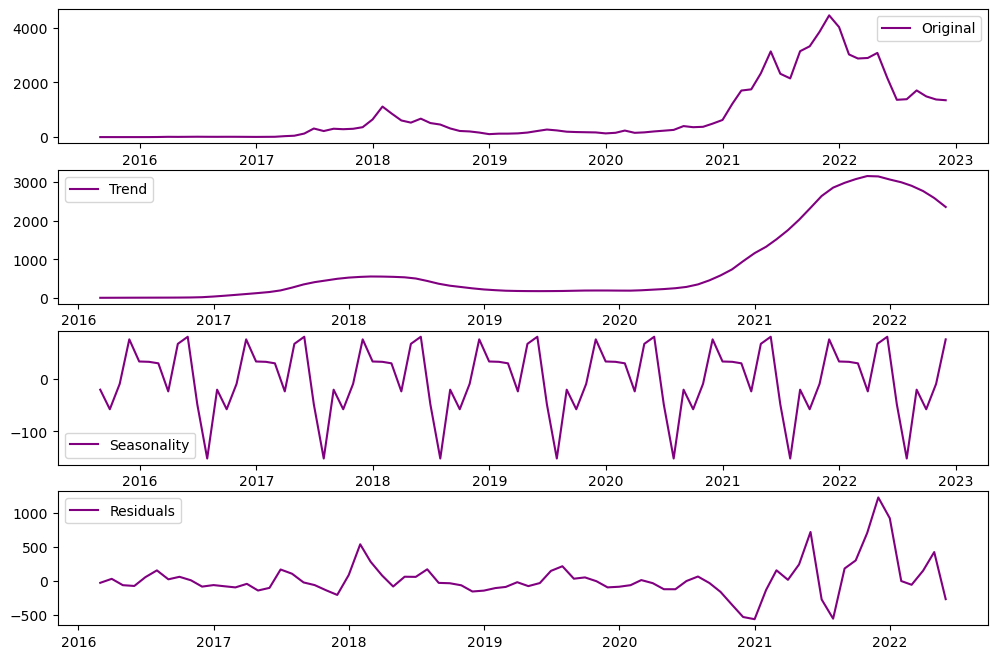

In [7]:
#Seasonal Decomposing
eth_df = eth.set_index(eth['Date'])
eth_month = eth_df.resample('M').mean()

decomposition = seasonal_decompose(eth_month['Close'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(eth_month['Close'], label='Original', color='purple')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='purple')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='purple')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='purple')
plt.legend(loc='best')
plt.show()

#The seasonal decomposing showed that there is a distinct seasonality after all. 
#It aslo showed that the residuals have been at their peak over 2021 and 2022. 
#The volatility of the crypto market, and in particular ETH, is notoriously high.
#However, seems like over this 2-year period the fluctuations have been much larger than before.
#Moreover, the general trend has been upwards up until 2021, and has been falling down in 2022.

In [8]:
# Box-Cox Transformations to Achieve Stationary Time Series
eth_month['close_box'], lmbda = stats.boxcox(eth_month['Close'])
print("Dickey–Fuller test: p=%f" % adfuller(eth_month['close_box'])[1])

Dickey–Fuller test: p=0.403423


In [9]:
# Seasonal differentiation (12 months)
eth_month['box_diff_seasonal_12'] = eth_month['close_box'] - eth_month['close_box'].shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(eth_month['box_diff_seasonal_12'][12:])[1])

Dickey–Fuller test: p=0.419111


In [10]:
# Regular differentiation
eth_month['box_diff2'] = eth_month['box_diff_seasonal_12'] - eth_month['box_diff_seasonal_12'].shift(1)  
print("Dickey–Fuller test: p=%f" % adfuller(eth_month['box_diff2'][13:])[1])

Dickey–Fuller test: p=0.000197


In [11]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(eth_month['close_box'], order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [12]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']

In [13]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   88
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -100.557
Date:                Wed, 01 Mar 2023   AIC                            205.115
Time:                        12:19:07   BIC                            210.047
Sample:                    08-31-2015   HQIC                           207.101
                         - 11-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3810      0.093      4.090      0.000       0.198       0.564
sigma2         0.5898      0.089      6.628      0.000       0.415       0.764
Ljung-Box (L1) (Q):                   0.13   Jarque-

In [14]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


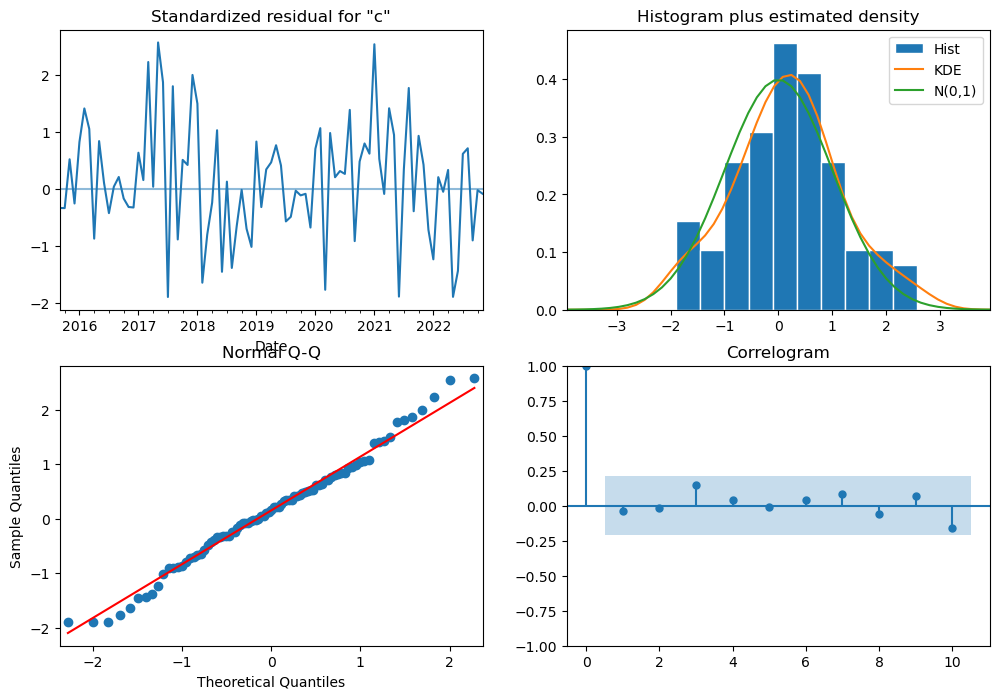

In [15]:
#Checking whether the residuals are uncorrelated and normally distributed
best_model.plot_diagnostics(figsize=(12, 8))
plt.show()

In [16]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

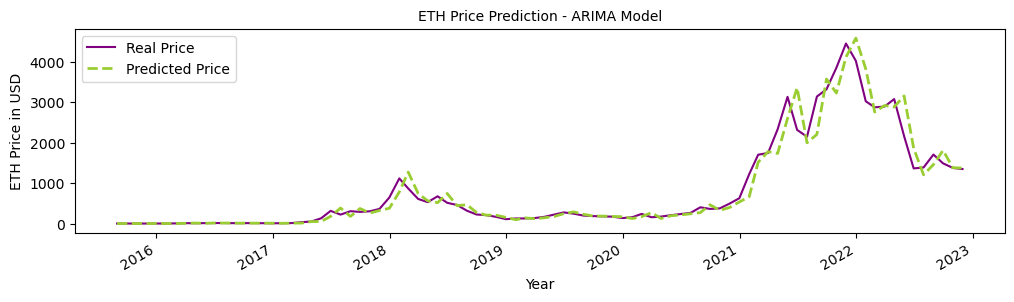

In [17]:
# Prediction
eth_month_pred = eth_month[['Close']]

date_list = eth_month.index
future = pd.DataFrame(index=date_list, columns= eth_month.columns)
eth_month_pred = pd.concat([eth_month_pred, future])

eth_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2015, 8, 31), end=datetime(2022, 11, 30)), lmbda)


plt.figure(figsize=(12,3))
plt.plot(eth_month_pred['Close'], color='purple', label='Real Price')
eth_month_pred['forecast'].plot(color='yellowgreen', ls='--', linewidth=2, label='Predicted Price')
plt.legend()
plt.title('ETH Price Prediction - ARIMA Model', fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('ETH Price in USD', fontsize=10)
plt.show()

In [18]:
#Validation
y_forecasted = eth_month_pred['forecast']
y_truth = eth_month_pred['Close']
y_truth = y_truth.dropna()
y_forecasted = y_forecasted.dropna()

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Root Mean Squared Error: {}'.format(round(rmse, 2)))

Root Mean Squared Error: 274.34


## Model II: Deep Convolutional Neural Network

In [19]:
data = eth.loc[:,['Date','Open','High','Low','Volume','Close']]

In [20]:
data = data.set_index('Date')
data.index = pd.to_datetime(data.index,unit='ns')

In [21]:
aim = 'Close'

In [22]:
train_data = data.iloc[200:]
test_data = data.iloc[:200]

In [23]:
def normalise_zero_base(continuous):
    return continuous / continuous.iloc[0] - 1

def normalise_min_max(continuous):
    return (continuous - continuous.min()) / (data.max() - continuous.min())

In [24]:
def extract_window_data(continuous, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(continuous) - window_len):
        tmp = continuous[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(continuous, aim, window_len=10, zero_base=True, test_size=0.2):
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[aim][window_len:].values
    y_test = test_data[aim][window_len:].values
    if zero_base:
        y_train = y_train / train_data[aim][:-window_len].values - 1
        y_test = y_test / test_data[aim][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [25]:
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
    data, aim, window_len = 5, zero_base = True, test_size = 0.2)

In [26]:
model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 2, activation = 'relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(filters = 64, kernel_size = 2, activation = 'relu'))
model.add(Conv1D(filters = 32, kernel_size = 2, activation = 'relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'nadam', loss = 'mse')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 128)            1408      
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 64)             16448     
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 32)             4128      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 50)                1650      
                                                        

In [28]:
result = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 32, epochs = 100, verbose=1, shuffle=True)

Epoch 1/100
77/77 [==============================] - 6s 32ms/step - loss: 0.0061 - val_loss: 0.0020
Epoch 2/100
77/77 [==============================] - 2s 22ms/step - loss: 0.0016 - val_loss: 7.5509e-04
Epoch 3/100
77/77 [==============================] - 2s 22ms/step - loss: 7.8025e-04 - val_loss: 3.2809e-04
Epoch 4/100
77/77 [==============================] - 2s 23ms/step - loss: 5.4594e-04 - val_loss: 3.8314e-04
Epoch 5/100
77/77 [==============================] - 2s 23ms/step - loss: 5.3767e-04 - val_loss: 4.5864e-04
Epoch 6/100
77/77 [==============================] - 2s 23ms/step - loss: 4.9785e-04 - val_loss: 2.2752e-04
Epoch 7/100
77/77 [==============================] - 2s 22ms/step - loss: 3.0528e-04 - val_loss: 5.9121e-04
Epoch 8/100
77/77 [==============================] - 2s 23ms/step - loss: 2.0259e-04 - val_loss: 1.5032e-04
Epoch 9/100
77/77 [==============================] - 2s 23ms/step - loss: 2.3436e-04 - val_loss: 1.5683e-04
Epoch 10/100
77/77 [====================

77/77 [==============================] - 2s 23ms/step - loss: 4.0197e-05 - val_loss: 7.1346e-05
Epoch 77/100
77/77 [==============================] - 2s 23ms/step - loss: 5.7103e-05 - val_loss: 6.6381e-05
Epoch 78/100
77/77 [==============================] - 2s 23ms/step - loss: 4.2586e-05 - val_loss: 2.6003e-04
Epoch 79/100
77/77 [==============================] - 2s 22ms/step - loss: 8.1727e-05 - val_loss: 5.2143e-05
Epoch 80/100
77/77 [==============================] - 2s 23ms/step - loss: 6.5172e-05 - val_loss: 2.0475e-04
Epoch 81/100
77/77 [==============================] - 2s 24ms/step - loss: 5.6952e-05 - val_loss: 7.0845e-05
Epoch 82/100
77/77 [==============================] - 2s 23ms/step - loss: 5.0570e-05 - val_loss: 5.3700e-05
Epoch 83/100
77/77 [==============================] - 2s 24ms/step - loss: 2.9344e-05 - val_loss: 4.9847e-05
Epoch 84/100
77/77 [==============================] - 2s 24ms/step - loss: 2.6979e-05 - val_loss: 4.5036e-05
Epoch 85/100
77/77 [============

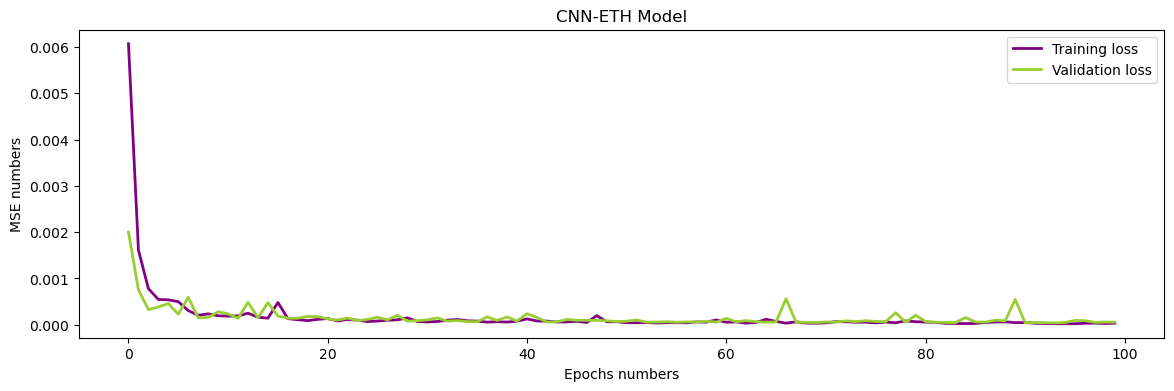

In [29]:
plt.figure(figsize=(14,4))
plt.plot(result.history['loss'],'r', linewidth = 2, label = 'Training loss', color = 'purple')
plt.plot(result.history['val_loss'], 'g',linewidth=2, label = 'Validation loss', color = 'yellowgreen')
plt.title('CNN-ETH Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.legend()
plt.show()

In [30]:
targets = test_data[aim][5:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

7/7 [==============================] - 0s 6ms/step


0.005553087093375497

In [31]:
SCORE_MSE = mean_squared_error(preds, y_test)
SCORE_MSE

5.663846811436389e-05

In [32]:
r2_score = r2_score(y_test, preds)
r2_score*100

99.66164739637182

In [33]:
preds = test_data[aim].values[:-5] * (preds + 1)
preds = pd.Series(index = targets.index, data = preds)

In [34]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(14, 4))
    ax.plot(line1, label=label1, linewidth=lw, color='purple')
    ax.plot(line2, label=label2, linewidth=lw, ls='--', color='yellowgreen')
    ax.set_ylabel('ETH Price in USD', fontsize=14)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.legend(loc='best', fontsize=12);

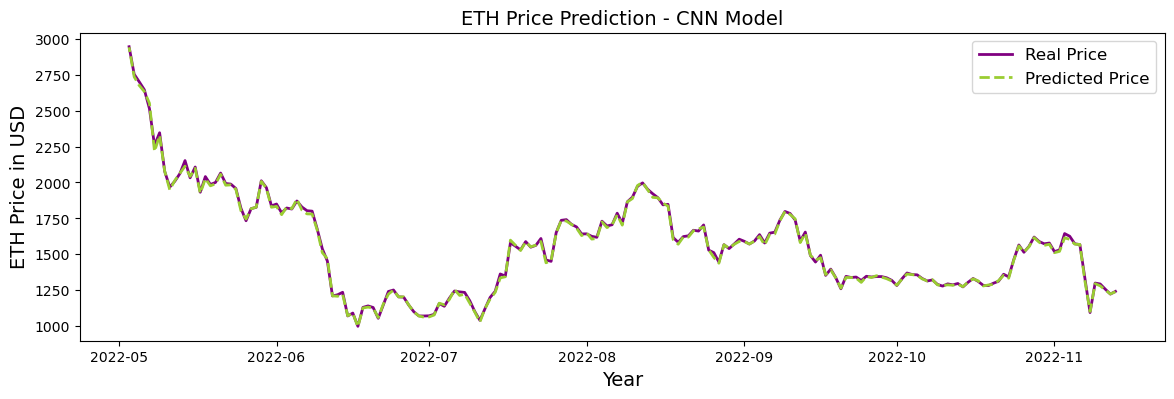

In [35]:
line_plot(targets, preds, 'Real Price', 'Predicted Price', title = 'ETH Price Prediction - CNN Model')